
# TP3 — ACP & Segmentation sur **HealthMind**
**But :** Résumer les variables, visualiser les profils et créer des groupes pour mieux cibler la prévention.



## Plan
1. Chargement & Pipeline de prétraitement  
2. ACP : variance expliquée, cercle des corrélations, biplot  
3. Clustering KMeans dans l'espace ACP : choix de k, visualisation, profilage  
4. Conclusions & recommandations


In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


df = pd.read_csv('D:\codePack\OneDrive\Desktop\ProjectsClouds\MentallHealthAwareness\HealthMind_Mental_Health_Data_3500.csv')

# df = pd.read_csv("/mnt/data/HealthMind_Mental_Health_Data_3500.csv")
df.head()


,User_ID,Age,Gender,Education_Level,Employment_Status,Work_Hours_Week,Sleep_Hours_Night,Exercise_Freq_Week,Social_Support,GAD-7_Score,PHQ-9_Score,Stress_Level_Scale,Coping_Mechanism,Risk_Level
0,1001,35,Female,University,Employed,50.790616,3.573649,4.0,Low,7,22,8.0,Socializing,Medium
1,1002,28,Male,University,Unemployed,0.000000,6.127009,1.0,Low,8,3,4.0,Work,Low
2,1003,37,Other,University,Unemployed,0.000000,5.571812,2.0,Medium,6,12,4.0,Gaming,Medium
3,1004,48,Female,University,Self-employed,80.000000,6.721314,2.0,Low,9,14,5.0,Gaming,Medium
4,1005,27,Male,University,Employed,49.670909,7.754259,3.0,Low,7,17,8.0,Isolation,Medium



### 1) Prétraitement (Pipeline)
- Numériques : imputation **médiane** + **RobustScaler**  
- Catégorielles : imputation **mode** + **OneHotEncoder** (ignore catégorie inconnue)  
- **Tout** est encapsulé dans un **ColumnTransformer** (propre, reproductible).


In [6]:

num_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()
for tgt in ["Risk_Level", "Stress_Level_Scale"]:
    if tgt in num_cols:
        num_cols.remove(tgt)
cat_cols = [c for c in df.columns if c not in num_cols]

num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")),
                     ("scaler", RobustScaler())])

cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                     ("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])
preprocess


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['User_ID', 'Age', 'Work_Hours_Week',
                                  'Sleep_Hours_Night', 'Exercise_Freq_Week',
                                  'GAD-7_Score', 'PHQ-9_Score']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Gender', 'Education_Level',
                                  'Employment_Status', 'Social_Support',
                                  'Stress_Level_Scale', 'Coping_Mechanism',
                                  'Risk_Level'])])


## 2) ACP : ajustement & éboulis
On décide du nombre d'axes à partir de la **variance cumulée** (~85%).


Variance expliquée par axe (%): [8.11 7.87 7.46 5.99 5.59 4.88 4.69 4.65 4.42 4.37]
Variance cumulée (%): [ 8.11 15.98 23.44 29.44 35.03 39.91 44.61 49.26 53.67 58.04]
Nombre d'axes gardés: 10


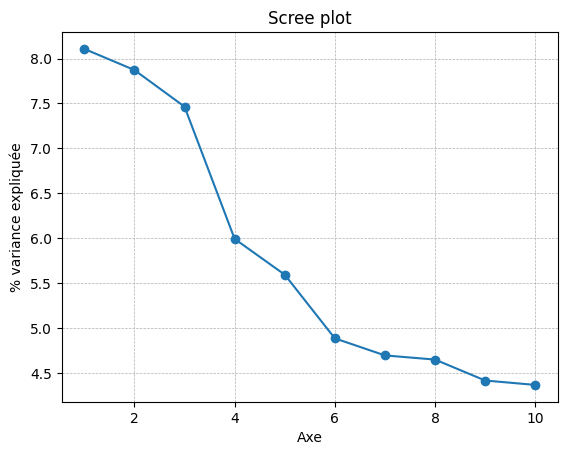

In [7]:

pca_probe = Pipeline([("prep", preprocess), ("pca", PCA(n_components=10, random_state=42))])
Z = pca_probe.fit_transform(df)
pca_obj = pca_probe.named_steps["pca"]
evr = pca_obj.explained_variance_ratio_
cum = evr.cumsum()

print("Variance expliquée par axe (%):", np.round(evr*100, 2))
print("Variance cumulée (%):", np.round(cum*100, 2))

n_keep = int(np.argmax(cum >= 0.85) + 1) if np.any(cum >= 0.85) else len(evr)
n_keep = max(2, n_keep)
print("Nombre d'axes gardés:", n_keep)

# Scree plot
plt.figure()
plt.plot(range(1, len(evr)+1), evr*100, marker="o")
plt.xlabel("Axe"); plt.ylabel("% variance expliquée"); plt.title("Scree plot")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()



### Cercle des corrélations & biplot
- On refait l'ACP avec `n_keep`.  
- **Cercle des corrélations** : variables numériques sur Dim1–Dim2.  
- **Biplot** : individus (points).


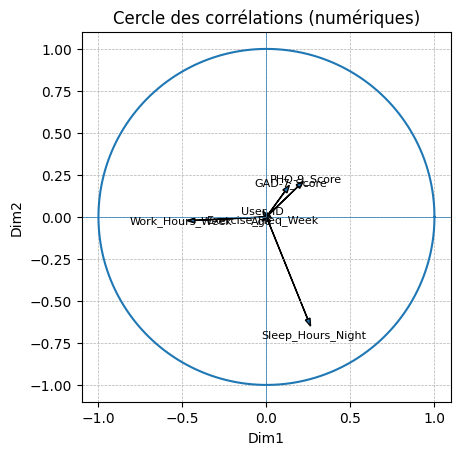

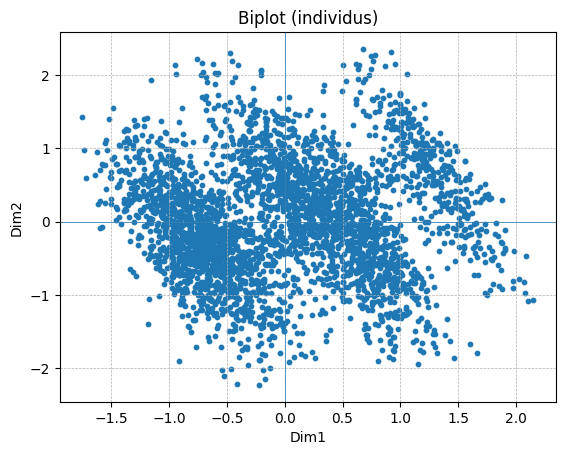

In [8]:

pca = Pipeline([("prep", preprocess), ("pca", PCA(n_components=n_keep, random_state=42))])
scores = pca.fit_transform(df)
pca_k = pca.named_steps["pca"]

feat_names = pca.named_steps["prep"].get_feature_names_out()
components = pca_k.components_
ev = pca_k.explained_variance_
loadings = components.T * np.sqrt(ev)

import re
num_mask = [name.startswith("num__") for name in feat_names]
num_names = [re.sub(r"^num__", "", n) for n, m in zip(feat_names, num_mask) if m]
num_load = loadings[num_mask, :]

# Cercle Dim1-Dim2
theta = np.linspace(0, 2*np.pi, 400)
plt.figure()
plt.plot(np.cos(theta), np.sin(theta))
plt.axhline(0, linewidth=0.5); plt.axvline(0, linewidth=0.5)
for i, var in enumerate(num_names):
    x, y = num_load[i, 0], num_load[i, 1]
    plt.arrow(0, 0, x, y, head_width=0.03, length_includes_head=True)
    plt.text(x*1.08, y*1.08, var, ha="center", va="center", fontsize=8)
plt.gca().set_aspect("equal", adjustable="box")
plt.xlim(-1.1, 1.1); plt.ylim(-1.1, 1.1)
plt.xlabel("Dim1"); plt.ylabel("Dim2"); plt.title("Cercle des corrélations (numériques)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

# Biplot (individus)
plt.figure()
plt.scatter(scores[:,0], scores[:,1], s=10)
plt.axhline(0, linewidth=0.5); plt.axvline(0, linewidth=0.5)
plt.xlabel("Dim1"); plt.ylabel("Dim2"); plt.title("Biplot (individus)")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()



## 3) Clustering KMeans (sur l'espace ACP)
> **Astuce** : exécute ce bloc après celui de l'ACP (il utilise `scores`).  
- On teste `k=2..7`, on retient le **k** avec meilleure **silhouette**.  
- On affiche la carte des clusters + un **profilage** (moyennes par cluster).


Silhouette: [(2, 0.13356230492405163), (3, 0.13710674679601098), (4, 0.14019527238229126), (5, 0.14208841014365634), (6, 0.12289642728013314), (7, 0.12768708223949546)]
Meilleur k = 5 (silhouette = 0.142)


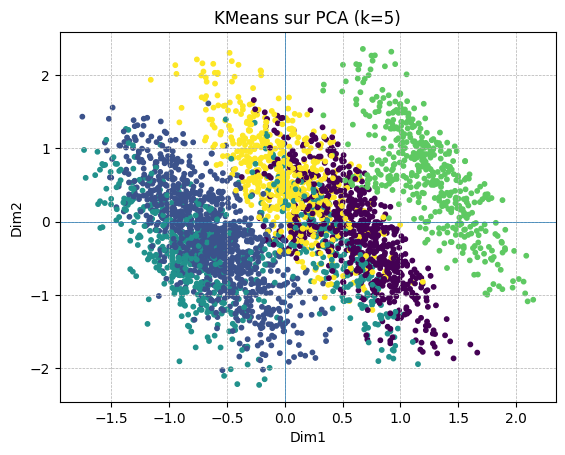

__cluster__
0     703
1    1092
2     661
3     441
4     603
Name: count, dtype: int64

,User_ID,Age,Work_Hours_Week,Sleep_Hours_Night,Exercise_Freq_Week,GAD-7_Score,PHQ-9_Score
__cluster__,,,,,,,
0,2743.12,30.20,9.15,6.52,2.95,9.89,12.77
1,2766.72,31.26,46.96,6.48,3.12,10.23,12.58
2,2735.83,30.63,31.84,6.46,3.03,4.61,4.70
3,2756.83,30.77,9.38,6.44,2.88,15.39,21.26
4,2741.19,30.85,46.33,6.41,2.96,15.17,21.55


In [9]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sil = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(scores)
    sil.append((k, silhouette_score(scores, labels)))

best_k, best_s = max(sil, key=lambda x: x[1])
print("Silhouette:", sil)
print(f"Meilleur k = {best_k} (silhouette = {best_s:.3f})")

km = KMeans(n_clusters=best_k, n_init=20, random_state=42).fit(scores)
labels = km.labels_

plt.figure()
plt.scatter(scores[:,0], scores[:,1], c=labels, s=10)
plt.axhline(0, linewidth=0.5); plt.axvline(0, linewidth=0.5)
plt.xlabel("Dim1"); plt.ylabel("Dim2"); plt.title(f"KMeans sur PCA (k={best_k})")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

df_prof = df.copy()
df_prof["__cluster__"] = labels
display(df_prof["__cluster__"].value_counts().sort_index())
num_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()
for tgt in ["Risk_Level", "Stress_Level_Scale"]:
    if tgt in num_cols:
        num_cols.remove(tgt)
display(df_prof.groupby("__cluster__")[num_cols].mean().round(2))



## 4) Conclusions & recommandations


**Principaux résultats ACP (pré-calculés ici)**  
- Axes conservés : **10**  
- Variance expliquée : **Dim1 = 8.1%**, **Dim2 = 7.9%** (cumulé Dim1+Dim2 = **16.0%**).  
- Variables numériques top sur **Dim1** : Work_Hours_Week (|loading|=0.47), Sleep_Hours_Night (|loading|=0.26), PHQ-9_Score (|loading|=0.22), GAD-7_Score (|loading|=0.14), Age (|loading|=0.03).
\n- Variables numériques top sur **Dim2** : Sleep_Hours_Night (|loading|=0.65), PHQ-9_Score (|loading|=0.21), GAD-7_Score (|loading|=0.19), User_ID (|loading|=0.03), Age (|loading|=0.03).
       
**Clustering** : code inclus plus bas (KMeans + silhouette), à exécuter dans le notebook pour obtenir k optimal et profils.


**Guide d'interprétation :**  
- **Dim1** = axe principal (max d'information). Les variables listées comme “top Dim1” expliquent sa direction.  
- **Dim2** = second facteur indépendant.  
- **Clusters** : lancez la cellule KMeans pour obtenir `k` optimal + tailles et profils, puis décrivez les groupes (ex. peu de sommeil, longues heures de travail, faible exercice…).  
- À partir des profils et des variables dominantes, proposez **3–5 recommandations** simples (sommeil, exercice, gestion du stress, consultation).
